In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import scipy 
import anndata
from scvi import dataset
from sklearn.utils import shuffle

/Users/joeyta/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
smartseq = pd.read_csv("ypx3sw2f7c-3/smartseq.csv")

In [3]:
SM_adata = anndata.read_csv("ypx3sw2f7c-3/smartseq.csv", first_column_names = True)

In [4]:
SM_adata = SM_adata.T

In [5]:
SM_metadata = pd.read_csv("ypx3sw2f7c-3/SMART-seq_VMH_metadata.csv")

In [6]:
SM_adata.obs["sample_name"] = SM_metadata["sample_name"].values
SM_adata.obs["cca_cluster_id"] = SM_metadata["smart_seq_cluster_id"].values
SM_adata.obs["cca_cluster"] = SM_metadata["smart_seq_cluster_label"].values
SM_adata.obs["sex_label"] = SM_metadata["sex_label"].values
SM_adata.obs["cca_cluster_color"] = SM_metadata["smart_seq_cluster_color"].values

In [7]:
np.random.seed(seed = 15)

In [8]:
metadata = pd.read_csv('ypx3sw2f7c-3/10x_metadata_VMH_neuron.csv')

In [9]:
cells_metadata = pd.read_csv('ypx3sw2f7c-3/10x_metadata_cell.csv')

In [10]:
m = anndata.read_mtx("ypx3sw2f7c-3/Female_Control_1/matrix.mtx")

In [12]:
def create_dataset(folder):
    path = "ypx3sw2f7c-3/" + folder + "/"
    matrix = anndata.read_mtx(path + 'matrix.mtx')
    origin = '10x_VMH_' + folder
    batch = cells_metadata.loc[cells_metadata['orig.ident'] == origin , ['sample_name']].values[0][0][0]
    t2g = pd.read_csv(path + 'genes.tsv', header = None, names = ['gene_id', 'gene_name'], sep = '\t')
    barcodes = pd.read_csv(path + 'barcodes.tsv', header = None, names = ['barcode'])
    barcodes['barcode'] = barcodes['barcode'].str.strip('-1')
    barcodes['barcode'] = str(batch) + '_' + barcodes['barcode']
    barcodes['cluster_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cluster_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cca_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_color'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['sex_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['sex_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['sex_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cluster_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['neuron_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_id']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_id']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_color']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_color']].values
    genes = t2g.gene_name.values
    matrix = matrix.T
    matrix.var["gene_name"] = genes
    matrix.var.index = matrix.var["gene_name"]
    matrix.obs["cell_barcode"] = barcodes.barcode.values
    matrix.obs["sex_label"] = barcodes.sex_label.values
    matrix.obs["cca_cluster"] = barcodes.cca_label.values
    matrix.obs['cca_cluster_id'] = barcodes.cca_id.values
    matrix.obs['cca_cluster_color'] = barcodes.cca_color.values
    matrix.obs['sample_name'] = [folder] * len(barcodes.barcode)
    values = np.nan_to_num((matrix.obs.cca_cluster_id).astype(np.float))
    labeled_cells = np.where(values != 0)[0]
    #print(len(labeled_cells))
    val = matrix.n_obs - 1 
    #random_cells = np.random.randint(low = 0, high = val, size = 1500)
    matrix = matrix[labeled_cells, :]
    if (len(labeled_cells) == 1):
        return 
    return dataset.AnnDatasetFromAnnData(matrix)
    return matrix
    #return labeled_cells

In [13]:
folders = ["Female_Control_1", "Female_Mating_not_receptive_1", "Female_Mating_not_receptive_2", "Female_Mating_not_receptive_3", "Female_Plain_1", "Male_Aggression_1", "Male_Aggression_2", "Male_Aggression_3", 
           "Male_Control_1", "Male_Control_2", "Male_Control_3", "Male_M-F_CI_dangled_1", "Male_M-F_CI_pencil_cup_1","Male_M-M_CI_dangled_1", "Male_M-M_CI_pencil_cup_1", "Male_Mating_1",
           "Male_Others_1", "Male_Others_3", "Male_Others_4", "Male_Plain_1", "Male_Plain_2", "Male_Social_Fear_Singly-housed_1", "Male_Social_Fear_Singly-housed_2"]

In [14]:
l = []

In [15]:
for f in folders:
    print(f)
    l.append(create_dataset(f))

Female_Control_1
[2020-09-11 15:19:31,032] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-09-11 15:19:31,537] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2020-09-11 15:19:31,545] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-11 15:19:31,546] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-11 15:19:32,795] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-11 15:19:33,093] INFO - scvi.dataset.dataset | Downsampled from 3194 to 3194 cells
Female_Mating_not_receptive_1
[2020-09-11 15:19:48,483] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-09-11 15:19:48,510] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2020-09-11 15:19:48,515] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-11 15:19:48,516] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-

In [16]:
l = list(filter(None, l))

In [17]:
gene_dataset = dataset.GeneExpressionDataset()

In [18]:
gene_dataset.populate_from_datasets(l)

[2020-09-11 15:29:36,811] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-09-11 15:29:36,812] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-09-11 15:29:37,442] INFO - scvi.dataset.dataset | Keeping 27998 genes
[2020-09-11 15:29:39,660] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-11 15:29:40,495] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-11 15:29:40,497] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-11 15:29:40,527] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-11 15:29:40,542] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-11 15:29:40,543] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-11 15:29:40,572] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-11 15:

In [19]:
adata = gene_dataset.to_anndata()

/Users/joeyta/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 30
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 2

mito_criteria = 5

n_top_genes = 2000

n_bins = 20

flavor="seurat"

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [22]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

In [23]:
SM_adata.obs["cell_counts"] = SM_adata.X.sum(axis=1)
SM_adata.var["gene_counts"] = nd(SM_adata.X.sum(axis=0))

SM_adata.obs["n_genes"] = nd((SM_adata.X>0).sum(axis=1))
SM_adata.var["n_cells"] = nd((SM_adata.X>0).sum(axis=0))

SM_mito_genes = SM_adata.var_names.str.startswith('mt-')
SM_adata.obs["percent_mito"] = SM_adata[:,SM_mito_genes].X.sum(axis=1)/SM_adata.X.sum(axis=1)*100

In [24]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [25]:
SM_adata.obs["pass_count_filter"] = SM_adata.obs["cell_counts"] > cell_threshold
SM_adata.obs["pass_mito_filter"] = SM_adata.obs.percent_mito < mito_criteria
SM_adata.var["pass_gene_filter"] = SM_adata.var["n_cells"] > gene_threshold

In [26]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [27]:
SM_cell_mask = np.logical_and(SM_adata.obs["pass_count_filter"].values, SM_adata.obs["pass_mito_filter"].values)
SM_gene_mask = SM_adata.var["pass_gene_filter"].values

In [28]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 15,065 cells x 27,998 genes
    New shape: 7,987 cells x 19,898 genes


In [29]:
print("Current Shape: {:,} cells x {:,} genes".format(SM_adata.shape[0], SM_adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(SM_cell_mask.sum(), SM_gene_mask.sum()))

Current Shape: 4,574 cells x 30,862 genes
    New shape: 4,574 cells x 26,320 genes


In [30]:
SM_data = SM_adata[SM_cell_mask, SM_gene_mask]

In [31]:
SM_data.layers["raw"] = SM_data.X
scale_num = 1000000
SM_data.layers["norm"] = normalize(SM_data.X, norm="l1", axis=1)*scale_num
SM_data.layers["log1p"] = np.log1p(SM_data.layers["norm"])
SM_data.uns = OrderedDict([("log1p", {"base":None})])
SM_data.X = SM_data.layers["log1p"]

In [32]:
data = adata[cell_mask, gene_mask]

In [33]:
data.layers["raw"] = data.X

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [34]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [35]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [36]:
data.X = data.layers["log1p"]

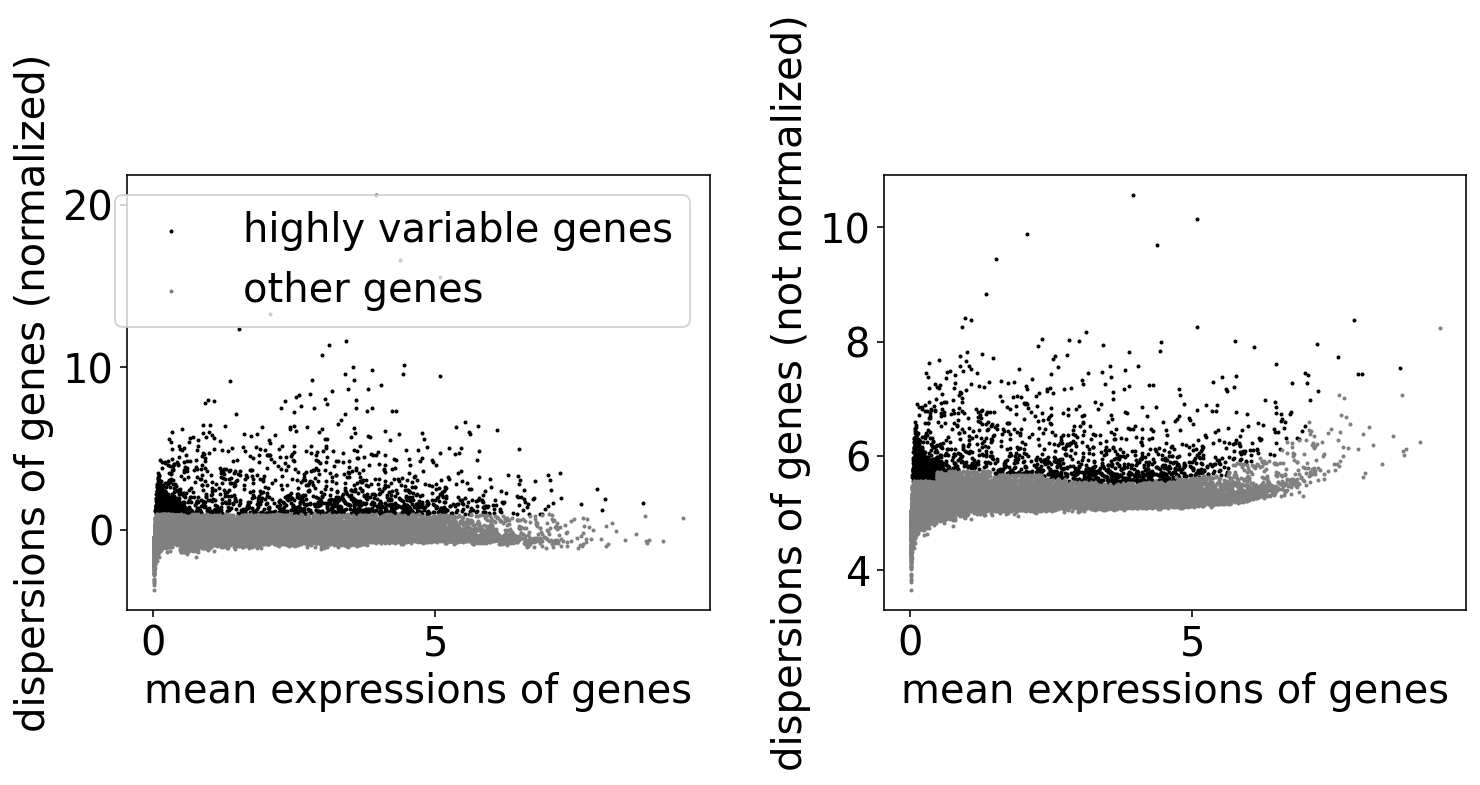

In [37]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values
sc.pl.highly_variable_genes(data)

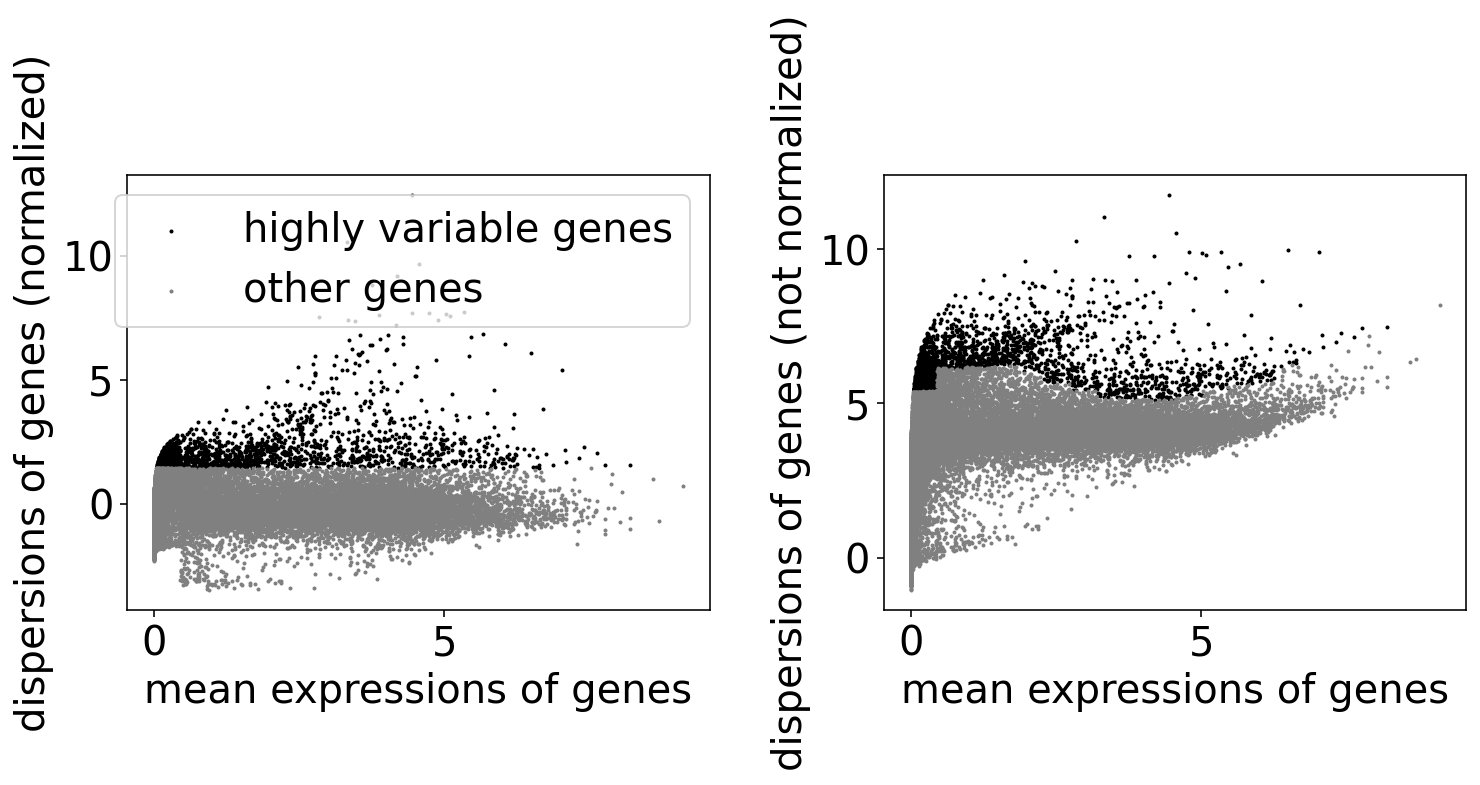

In [38]:
sc.pp.highly_variable_genes(SM_data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
SM_hvg_mask = SM_data.var.highly_variable.values
sc.pl.highly_variable_genes(SM_data)

In [39]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"]
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 5.21 s, sys: 2.86 s, total: 8.06 s
Wall time: 8.29 s


In [40]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = SM_data.layers["log1p"]
SM_data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
SM_data.X = SM_data.layers["scale"]

del mat

CPU times: user 3.89 s, sys: 2.05 s, total: 5.94 s
Wall time: 6.12 s


In [41]:
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

In [42]:
#PCA to 10D
X = data.X[:, hvg_mask]
tsvd = TruncatedSVD(n_components=num_PCA)

In [43]:
# PCA
X = SM_data.X[:,SM_hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
SM_data.obsm["X_pca"] = tsvd.fit_transform(X)

In [44]:
import louvain

In [45]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
sc.tl.louvain(data)

In [46]:
sc.pp.neighbors(SM_data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
sc.tl.louvain(SM_data)
SM_hvg_data = SM_data[:, SM_hvg_mask]

In [47]:
hvg_data = data[:, hvg_mask]

In [48]:
hvg_data

View of AnnData object with n_obs × n_vars = 7987 × 1999
    obs: 'sex_label', 'cell_types', 'cca_cluster_color', 'cell_barcode', 'cca_cluster', 'sample_name', 'batch_indices', 'cca_cluster_id', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'louvain'
    var: 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'louvain'
    obsm: 'X_pca'
    layers: 'raw', 'norm', 'log1p', 'scale'
    obsp: 'distances', 'connectivities'

In [49]:
copy = hvg_data.copy()
copy.obs["nca_label"] = copy.obs["sample_name"]
hvg_data.obs["nca_label"] = hvg_data.obs["cca_cluster"]
tenx = hvg_data.concatenate(copy, join = "outer")

Trying to set attribute `.obs` of view, copying.


In [50]:
X = tenx.X
y = tenx.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state)
tenx.obsm["X_nca"] = nca.fit_transform(X, y)

In [51]:
# t-SNE the NCA projection
X = tenx.obsm["X_nca"]
tenx_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
tenx.obsm["X_nca_tsne"] = tenx_tsne.fit_transform(X)

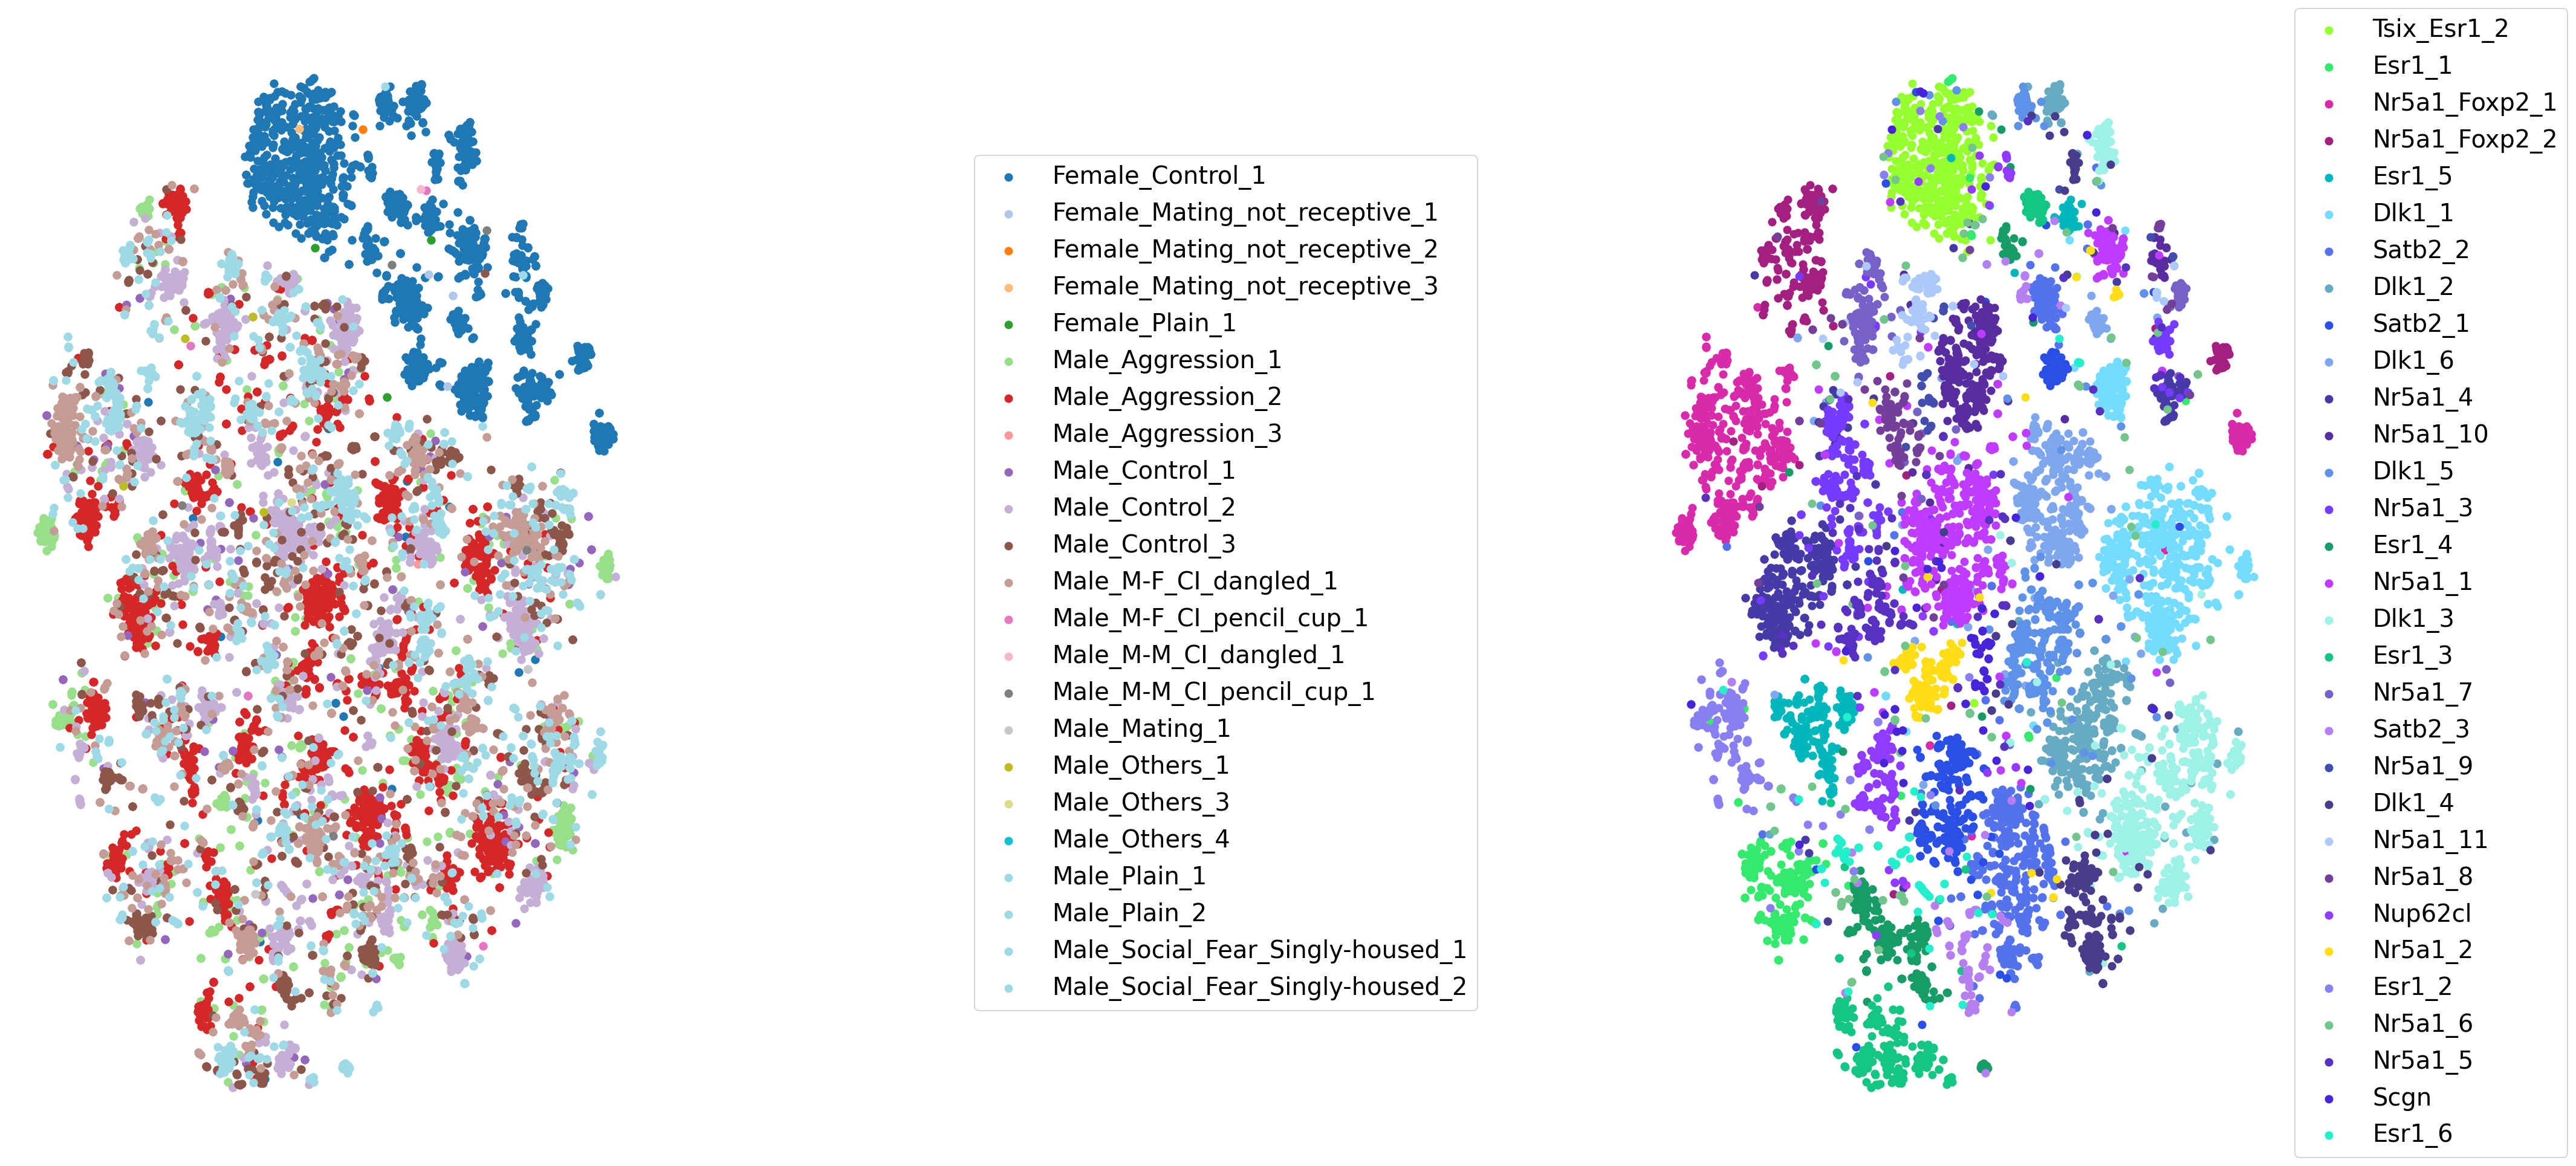

In [52]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(30,15))
cmap = cm.get_cmap("tab20")
for i, f in (enumerate(folders)):
    XX = tenx[tenx.obs.sample_name == f,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=f, color = cmap(i))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
clusters = pd.unique(tenx.obs.cca_cluster.values)
colors = pd.unique(tenx.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = tenx[tenx.obs.nca_label == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, label=c, color = idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.tight_layout()

In [53]:
# NCA
#X = hvg_data.X
#y = hvg_data.obs.louvain.values # you could use louvain here also

#nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
#hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [54]:
# NCA
#X = hvg_data.X
#y = hvg_data.obs.cca_cluster_id.values # you could use louvain here also

#nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
#hvg_data.obsm["X_paper_nca"] = nca.fit_transform(X, y)

In [55]:
#Check for overfitting
X = hvg_data.obsm["X_pca"]
y = hvg_data.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [56]:
# NCA
X = SM_hvg_data.obsm["X_pca"]
y = SM_hvg_data.obs.cca_cluster_id.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state, init="identity")
SM_hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [57]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

In [58]:
# t-SNE the NCA projection
X = hvg_data.obsm["X_nca"]
hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
hvg_data.obsm["X_nca_tsne"] = hvg_tsne.fit_transform(X)


In [59]:
#Check for overfitting
from sklearn.utils import shuffle
cluster_ids = hvg_data.obs.cca_cluster_id.values
cluster_colors = hvg_data.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
hvg_data.obs["random_labels"] = cluster_ids
hvg_data.obs["random_colors"] = cluster_colors
X = hvg_data.obsm["X_pca"]
y = hvg_data.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
hvg_data.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = hvg_data.obsm["X_nca_shuffled"]
hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
hvg_data.obsm["X_nca_tsne_shuffled"] = hvg_tsne.fit_transform(X)

In [60]:
#Check for overfitting
SM_cluster_ids = SM_hvg_data.obs.cca_cluster_id.values
SM_cluster_colors = SM_hvg_data.obs.cca_cluster_color.values
SM_cluster_ids, SM_cluster_colors = shuffle(SM_cluster_ids, SM_cluster_colors, random_state=0)
SM_hvg_data.obs["random_labels"] = SM_cluster_ids
SM_hvg_data.obs["random_colors"] = SM_cluster_colors
X = SM_hvg_data.obsm["X_pca"]
y = SM_hvg_data.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
SM_hvg_data.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = SM_hvg_data.obsm["X_nca_shuffled"]
SM_hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
SM_hvg_data.obsm["X_nca_tsne_shuffled"] = SM_hvg_tsne.fit_transform(X)

In [61]:
# t-SNE the NCA projection
X = SM_hvg_data.obsm["X_nca"]
SM_hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
SM_hvg_data.obsm["X_nca_tsne"] = SM_hvg_tsne.fit_transform(X)

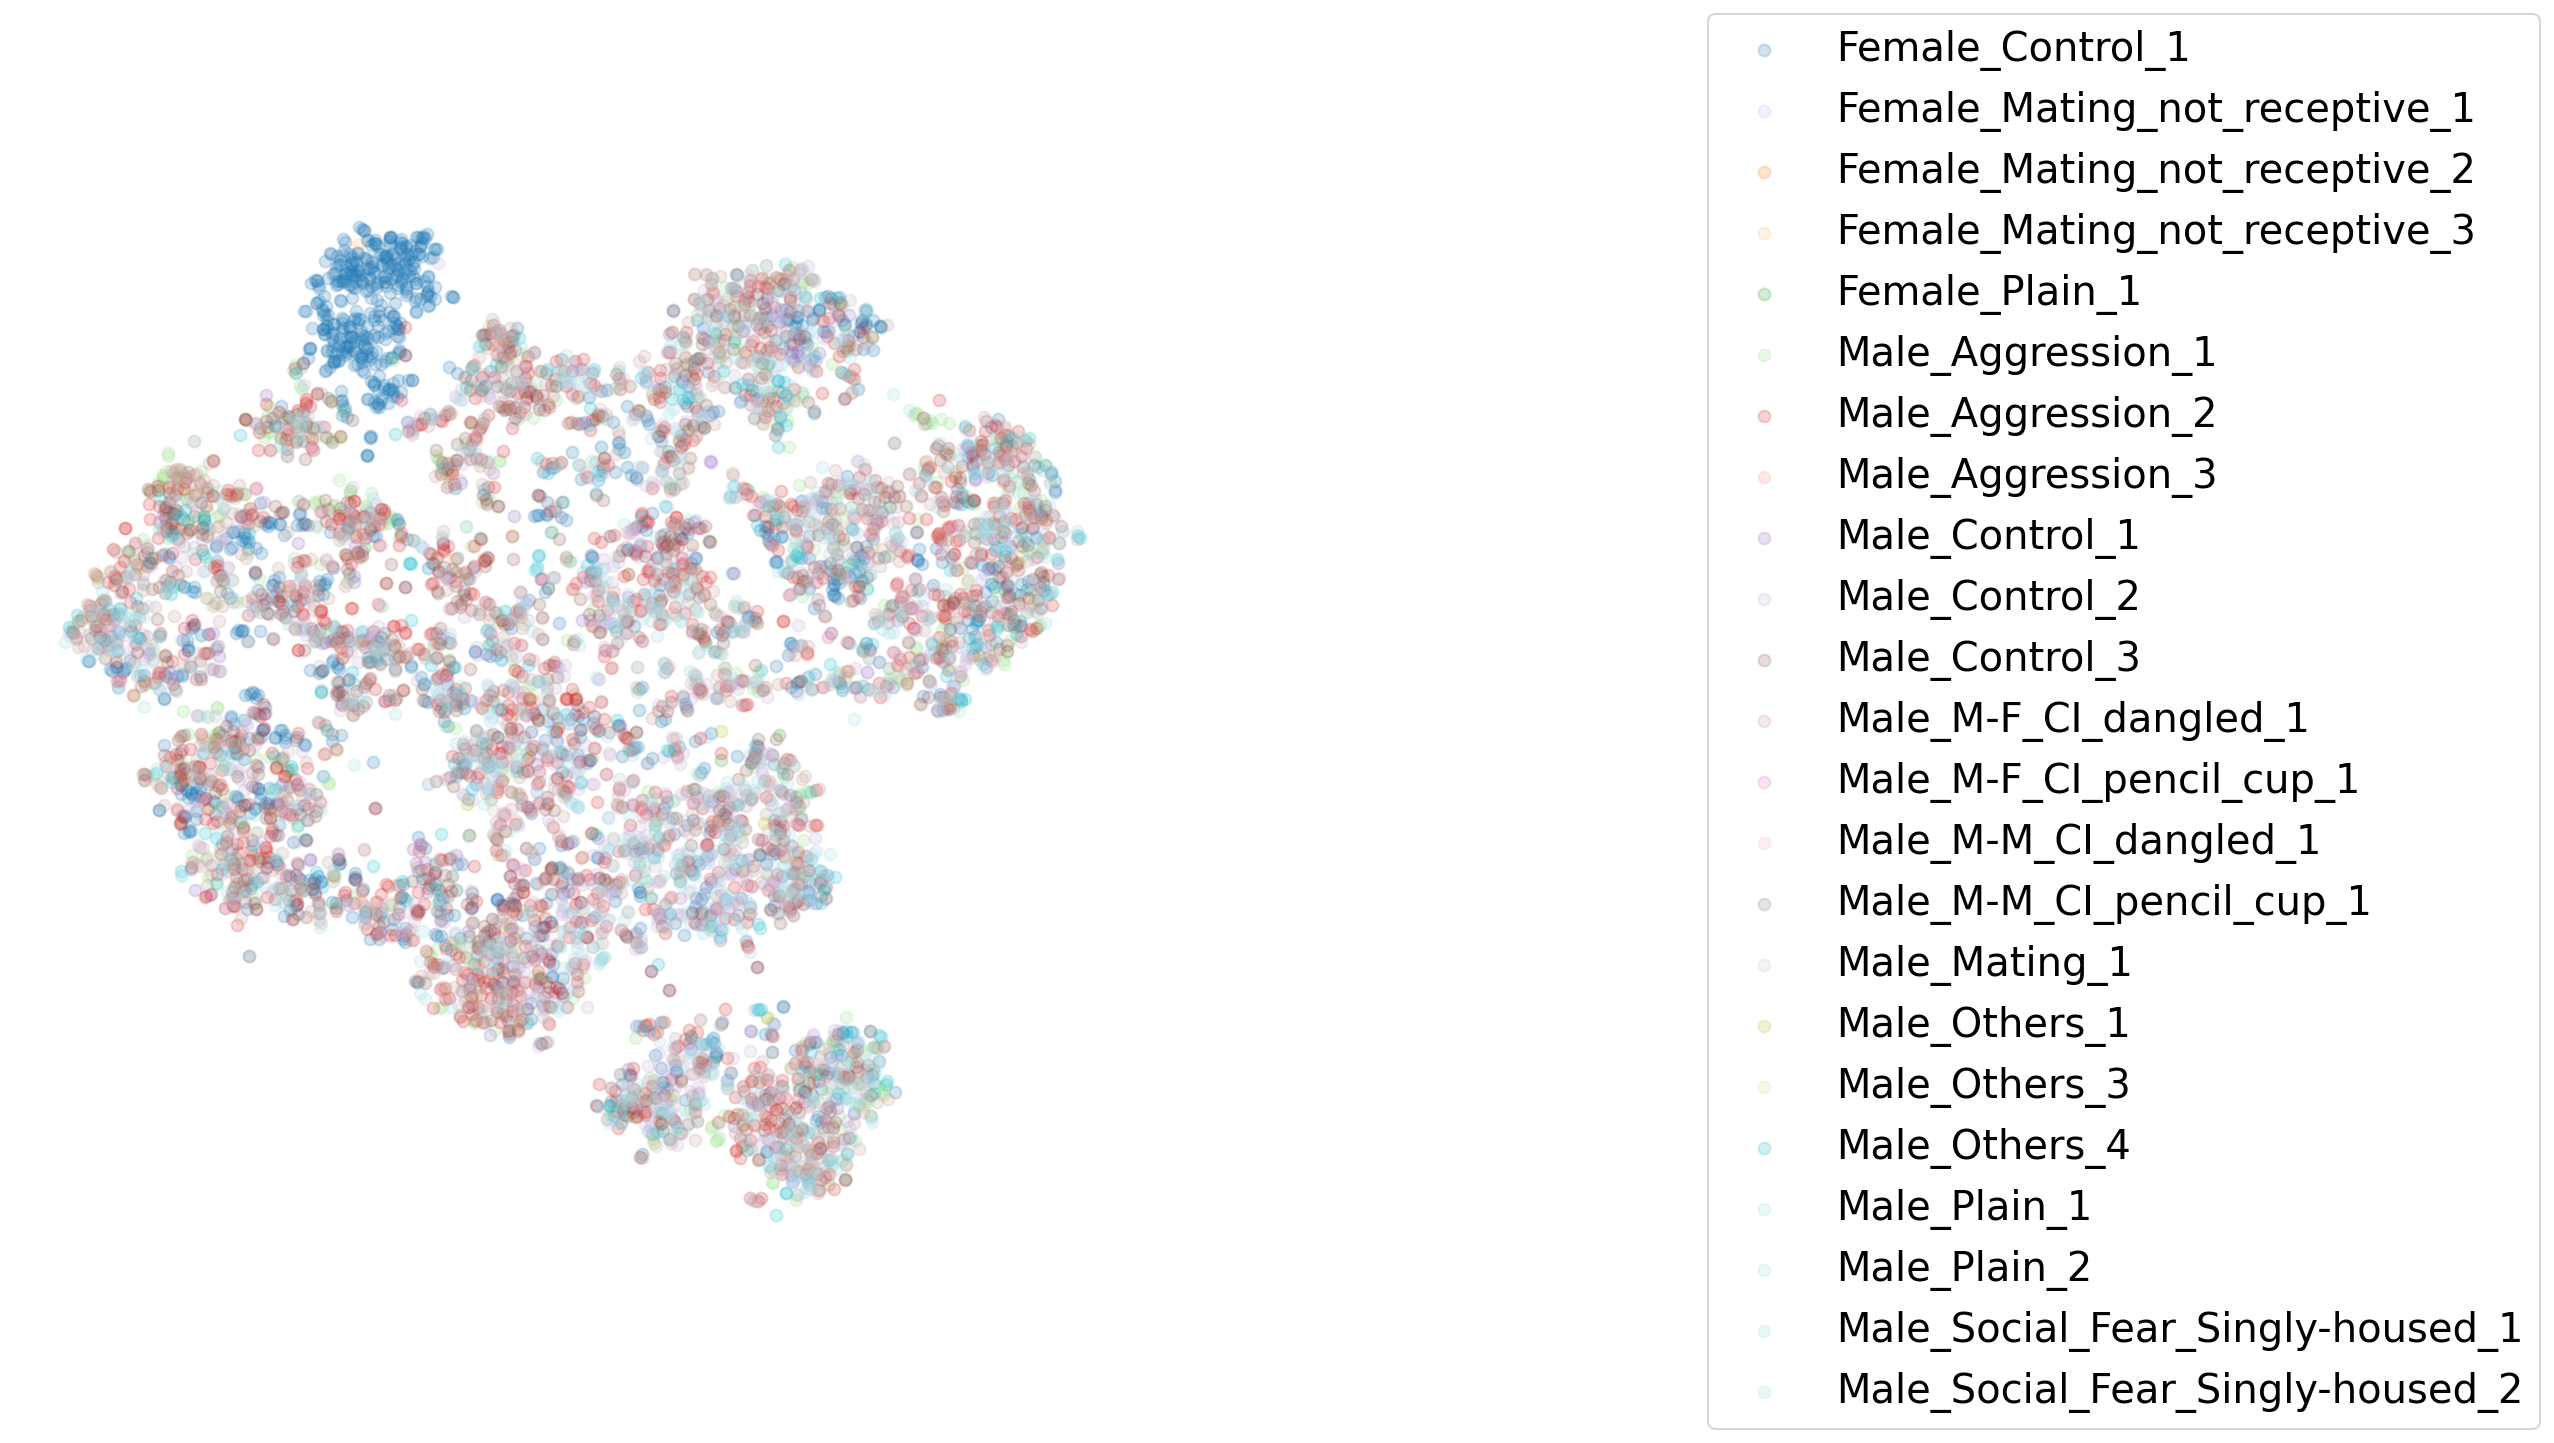

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = cm.get_cmap("tab20")
for i, f in (enumerate(folders)):
    XX = hvg_data[hvg_data.obs.batch_indices == i,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=f, alpha = 0.2, color = cmap(i))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()

No handles with labels found to put in legend.


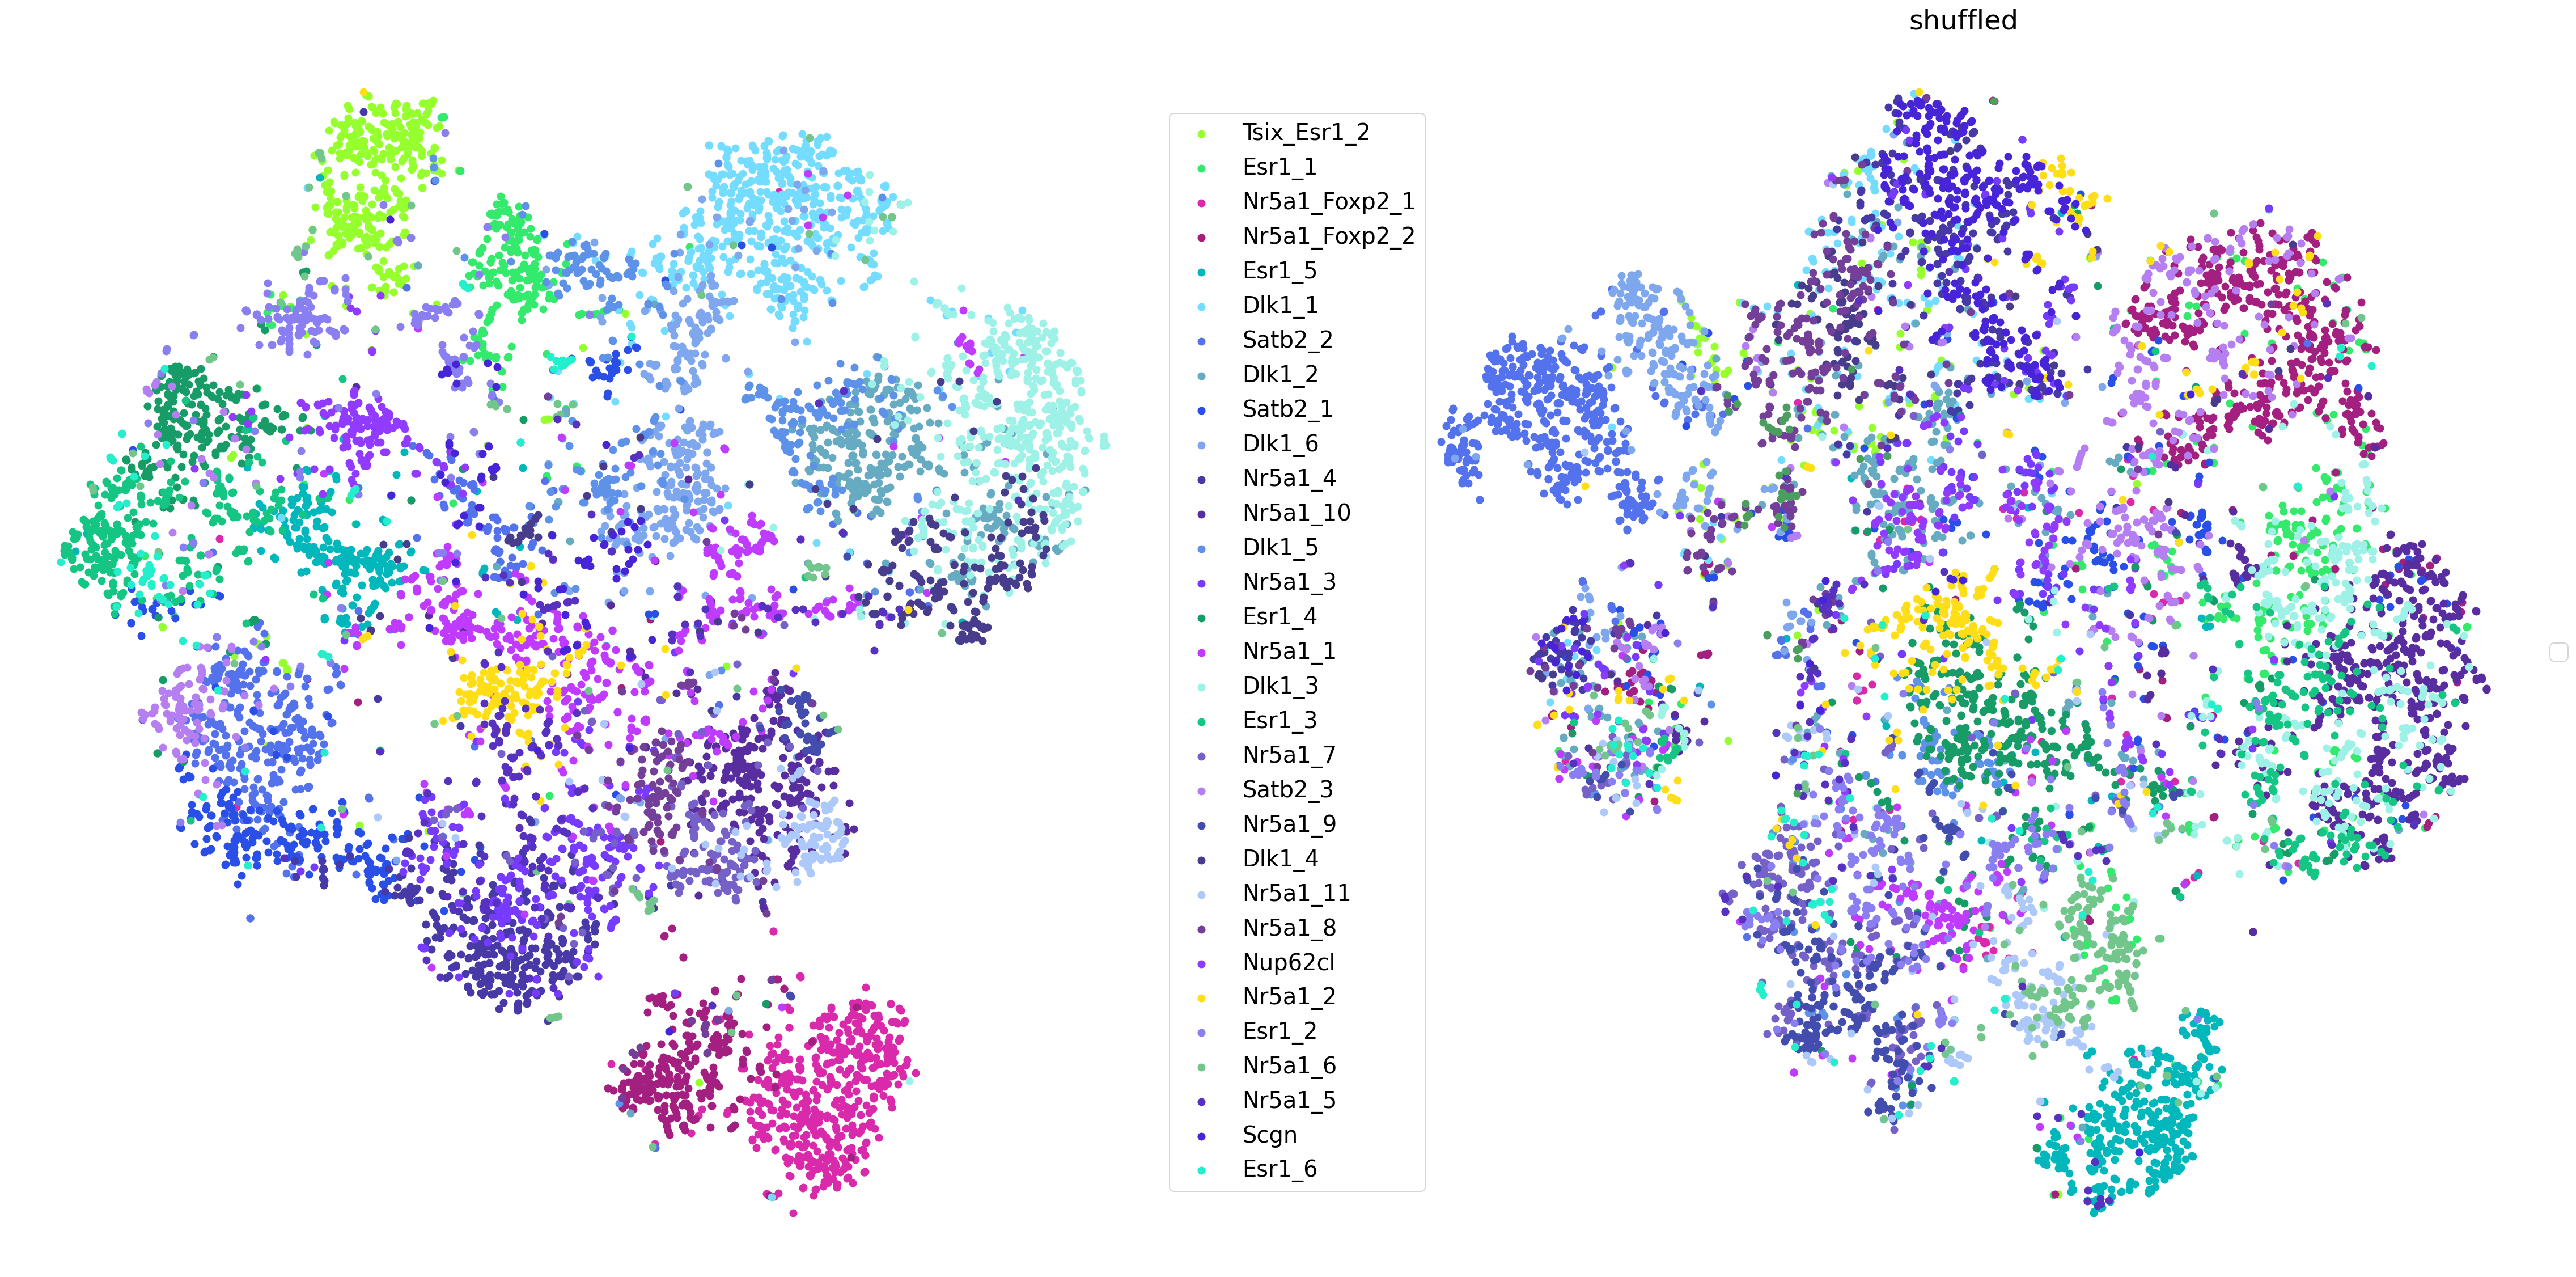

In [63]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(hvg_data.obs.cca_cluster.values)
colors = pd.unique(hvg_data.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = hvg_data[hvg_data.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(hvg_data.obs.cca_cluster_color.values).astype(str)
clusters = pd.unique(hvg_data.obs.random_labels)
for idx, c in (zip(colors, clusters)):
    XX = hvg_data[hvg_data.obs.cca_cluster_id == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color = idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [64]:
combined = hvg_data.concatenate(SM_hvg_data, join = "outer")

In [65]:
combined.X = np.nan_to_num(combined.X)

In [66]:
combined

AnnData object with n_obs × n_vars = 12561 × 3569
    obs: 'sex_label', 'cell_types', 'cca_cluster_color', 'cell_barcode', 'cca_cluster', 'sample_name', 'batch_indices', 'cca_cluster_id', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'louvain', 'nca_label', 'random_labels', 'random_colors', 'batch'
    var: 'gene_name-0', 'gene_counts-0', 'n_cells-0', 'pass_gene_filter-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_counts-1', 'n_cells-1', 'pass_gene_filter-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_nca', 'X_nca_tsne', 'X_nca_shuffled', 'X_nca_tsne_shuffled'
    layers: 'raw', 'norm', 'log1p', 'scale'

In [67]:
# PCA
X = combined.X

tsvd = TruncatedSVD(n_components=num_PCA)
combined.obsm["X_pca"] = tsvd.fit_transform(X)

In [68]:
#tsne
X = combined.obsm["X_pca_10D"] 
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_pca_tsne"] = tsne.fit_transform(X)

KeyError: 'X_pca_10D'

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.cca_cluster == cluster, :].obsm["X_pca_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
technology = combined.copy()

In [ ]:
technology.obs["nca_label"] = technology.obs.batch.values
technology.obs["shuffled_label"] = shuffle(technology.obs.batch.values, random_state = state)

In [ ]:
combined.obs["nca_label"] = combined.obs["cca_cluster"].values
combined.obs["shuffled_label"] = shuffle(combined.obs.cca_cluster.values, random_state = state)
duplicate = combined.copy()
duplicate.obs["nca_label"] = duplicate.obs["sex_label"].values
duplicate.obs["shuffled_label"] = shuffle(duplicate.obs.sex_label.values, random_state = state)
double = combined.concatenate(duplicate, join = "outer")

In [ ]:
new_dataset = technology.concatenate(combined, join = "outer")

In [ ]:
X = new_dataset.obsm["X_pca"]
y = new_dataset.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
nca.fit(X, y)
A = combined.obsm["X_pca"]
b = combined.obs.nca_label.values
combined.obsm ["X_nca"] = nca.fit_transform(A, b)
A = combined.obsm["X_pca"]
b = combined.obs.shuffled_label.values
combined.obsm["X_nca_shuffled"] = nca.fit_transform(A, b)

In [ ]:
X = combined.obsm["X_nca_shuffled"]
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_nca_shuffled_tsne"] = tsne.fit_transform(X)

In [ ]:
X = combined.obsm["X_nca"]
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.shuffled_label == cluster, :].obsm["X_nca_shuffled_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.cca_cluster == cluster, :].obsm["X_nca_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
X = double.obsm["X_pca"]
y = double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
nca.fit(X, y)
A = combined.obsm["X_pca"]
b = combined.obs.nca_label.values
combined.obsm["X_nca_gender"] = nca.fit_transform(A, b)
C = combined.obsm["X_pca"]
d = combined.obs.shuffled_label.values
combined.obsm["X_nca_gender_shuffled"] = nca.fit_transform(C, d)

In [ ]:
X = combined.obsm["X_nca_gender_shuffled"]
tsne = TSNE(n_components = num_TSNE, random_state = state, metric = metric)
combined.obsm["X_gender_shuffled_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.shuffled_label.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.shuffled_label == c,:].obsm["X_gender_shuffled_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (.95, 0.5))
XX = combined[combined.obs.sex_label == 'F',:].obsm["X_gender_shuffled_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r', alpha = 0.7)
XX = combined[combined.obs.sex_label == 'M',:].obsm["X_gender_shuffled_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b', alpha = 0.3)
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
X = combined.obsm["X_nca_gender"]
tsne = TSNE(n_components = num_TSNE, random_state = state, metric = metric)
combined.obsm["X_gender_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_gender_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (.95, 0.5))
XX = combined[combined.obs.sex_label == 'F',:].obsm["X_gender_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r', alpha = 0.7)
XX = combined[combined.obs.sex_label == 'M',:].obsm["X_gender_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b', alpha = 0.3)
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
shuffled_labels = shuffle(duplicate.obs["nca_label"].values, random_state = 0)
duplicate.obs["nca_label"] = shuffled_labels
shuffled_double = combined.concatenate(duplicate, join = "outer")

In [ ]:
X = shuffled_double.obsm["X_pca"]
y = shuffled_double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
shuffled_double.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
X = shuffled_double.obsm["X_nca"]
double_tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
shuffled_double.obsm["X_nca_tsne"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(shuffled_double.obs.cca_cluster.values)
colors = pd.unique(shuffled_double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = shuffled_double[shuffled_double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
XX = shuffled_double[shuffled_double.obs.nca_label == 'F',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r')
XX = shuffled_double[shuffled_double.obs.nca_label == 'M',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b')
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
X = double.obsm["X_pca"]
y = double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init="identity")
double.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# t-SNE the NCA projection
X = double.obsm["X_nca"]
double_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
double.obsm["X_nca_tsne"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(double.obs.cca_cluster.values)
colors = pd.unique(double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = double[double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
XX = double[double.obs.sex_label == 'F',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r')
XX = double[double.obs.sex_label == 'M',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b')
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
#Check for overfitting
cluster_labels = double.obs.nca_label.values
cluster_colors = double.obs.cca_cluster_color.values
cluster_labels, cluster_colors = shuffle(cluster_labels, cluster_colors, random_state=0)
double.obs["random_labels"] = cluster_labels
double.obs["random_colors"] = cluster_colors
X = double.obsm["X_pca"]
y = double.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init = "identity")
double.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = double.obsm["X_nca_shuffled"]
double_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
double.obsm["X_nca_tsne_shuffled"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(double.obs.cca_cluster.values)
colors = pd.unique(double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = double[double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(double.obs.random_colors.values).astype(str)
clusters = pd.unique(double.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = double[double.obs.random_labels == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    #ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
#Check for overfitting
X = combined.obsm["X_pca"]
y = combined.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
combined.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
#Check for overfitting
X = combined.X
y = combined.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state)
combined.obsm["X_sklearn_nca"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_sklearn_nca"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_sklearn_nca_tsne"] = combined_tsne.fit_transform(X)

In [ ]:
#Check for overfitting
cluster_ids = combined.obs.cca_cluster_id.values
cluster_colors = combined.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
combined.obs["random_labels"] = cluster_ids
combined.obs["random_colors"] = cluster_colors
X = combined.X
y = combined.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state)
combined.obsm["X_sklearn_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_sklearn_nca_shuffled"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_sklearn_nca_tsne_shuffled"] = combined_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_sklearn_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(combined.obs.random_colors.values).astype(str)
clusters = pd.unique(combined.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = combined[combined.obs.random_labels == c,:].obsm["X_sklearn_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
# t-SNE the NCA projection
X = combined.obsm["X_nca"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_nca_tsne"] = combined_tsne.fit_transform(X)

In [ ]:
#Check for overfitting
cluster_ids = combined.obs.cca_cluster_id.values
cluster_colors = combined.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
combined.obs["random_labels"] = cluster_ids
combined.obs["random_colors"] = cluster_colors
X = combined.obsm["X_pca"]
y = combined.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
combined.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_nca_shuffled"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_nca_tsne_shuffled"] = combined_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_sklearn_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color = idx)
plt.title("PCA Initialized")
ax2.set_axis_off()
#ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(combined.obs.random_colors.values).astype(str)
clusters = pd.unique(combined.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = combined[combined.obs.random_labels == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
combined.obs.sex_label

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
X = SM_hvg_data.X
y = SM_hvg_data.obs.SM_cluster_label
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = hvg_data[hvg_data.obs.batch_indices <= 4,:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = hvg_data[hvg_data.obs.batch_indices > 4,:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = hvg_data[hvg_data.obs.batch_indices <= 4,:].obsm["X_paper_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = hvg_data[hvg_data.obs.batch_indices > 4,:].obsm["X_paper_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = hvg_data.obsm["X_nca_tsne"][:,0]
y = hvg_data.obsm["X_nca_tsne"][:,1]
c = hvg_data.obs["louvain"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = SM_hvg_data.obsm["X_nca_tsne"][:,0]
y = SM_hvg_data.obsm["X_nca_tsne"][:,1]
c = SM_hvg_data.obs["SM_cluster_id"].astype(int)
labels = (SM_hvg_data.obs["SM_cluster_label"]).astype(str)
ax.scatter(x, y, c = c, cmap='tab20', label = labels)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = SM_hvg_data[SM_hvg_data.obs.sex_label == "F",:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = SM_hvg_data[SM_hvg_data.obs.sex_label == "M",:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
sc.tl.rank_genes_groups(SM_hvg_data, "SM_cluster_id", method='wilcoxon', corr_method="bonferroni")

In [ ]:
SM_genes = pd.DataFrame(SM_hvg_data.uns['rank_genes_groups']['names']).to_numpy()
SM_pvals = pd.DataFrame(SM_hvg_data.uns['rank_genes_groups']['pvals']).to_numpy()

In [ ]:
SM_pvals

In [ ]:
unique = np.unique(SM_data.obs.louvain.values).astype(str)
SM_markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])
unique_id = np.unique(SM_data.obs.SM_cluster_id.values).astype(str)
SM_markers = pd.DataFrame(index = unique_id, columns = ["gene_name", "p_value"])

In [ ]:
unique_id

In [ ]:
for un, u in enumerate(unique_id):
    g = SM_genes[:,un]
    p = SM_pvals[:,un]
    SM_markers.loc[u]["gene_name"]  = g.tolist()
    SM_markers.loc[u]["p_value"] = p.tolist()

In [ ]:
SM_markers_gene = SM_markers_gene.apply(pd.Series.explode).reset_index()
SM_markers_gene = SM_markers_gene.rename(columns={"index":'louvain'})
SM_markers = SM_markers.apply(pd.Series.explode).reset_index()
SM_markers = SM_markers.rename(columns={"index": "SM_id"})
SM_cluster = SM_markers.drop_duplicates(["SM_id"])["SM_id"].values
SM_genes = SM_markers.drop_duplicates(["SM_id"])["gene_name"].values

In [ ]:
SM_specific_cluster = SM_markers_gene.drop_duplicates(["louvain"])["louvain"].values
SM_specific_gene = SM_markers_gene.drop_duplicates(["louvain"])["gene_name"].values

In [ ]:
len(c)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(SM_hvg_data.obs["SM_cluster_id"].values.astype(int))
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, SM_genes)):
    XX = SM_hvg_data[SM_hvg_data.obs.SM_cluster_id == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx/10), label= cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [ ]:
unique_neuron_clusters = pd.unique(np.nan_to_num(hvg_data.obs.neuron_cluster_id))

In [ ]:
unique_cca_clusters = pd.unique(np.nan_to_num(hvg_data.obs.cca_cluster_id))

In [ ]:
unique_cca_labels = pd.unique(hvg_data.obs.cca_cluster)

In [ ]:
unique_neuron_clusters[0] = -1.0
unique_neuron_clusters[1] = 0.0

In [ ]:
unique_cca_clusters = unique_cca_clusters.astype(float)

In [ ]:
unique_neuron_labels = pd.unique(hvg_data.obs.neuron_cluster)

In [ ]:
np.sum(unique_cca_clusters)

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_cca_clusters, unique_cca_labels):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label = cluster, color = cmap(idx/100))
ax.set_axis_off()
ax.legend(title = 'VMH_neuron_cca_cluster', loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("VMH_neuron_cca_clusters")

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_cca_clusters, unique_cca_labels):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_paper_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label = cluster, color = cmap(idx/100))
ax.set_axis_off()
ax.legend(title = 'VMH_neuron_cca_cluster', loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("VMH_neuron_cca_clusters")

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_neuron_clusters, unique_neuron_labels):
    XX = hvg_data[hvg_data.obs.neuron_cluster == cluster,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=cluster, alpha = 0.5, color = cmap(idx))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()


In [ ]:
non_null = hvg_data.obs.cca_cluster.values

In [ ]:
hvg_data.obs.cca_cluster_id = hvg_data.obs.cca_cluster_id.astype('category')

In [ ]:
sc.tl.rank_genes_groups(hvg_data, "cca_cluster", method='wilcoxon', corr_method="bonferroni")

In [ ]:
genes = pd.DataFrame(hvg_data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(hvg_data.uns['rank_genes_groups']['pvals']).to_numpy()

In [ ]:
unique = np.unique(data.obs.cca_cluster.values).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [ ]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [ ]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'cca'})

In [ ]:
specific_cluster = markers_gene.drop_duplicates(["cca"])["cca"].values
specific_gene = markers_gene.drop_duplicates(["cca"])["gene_name"].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

c = pd.unique(hvg_data.obs["cca_cluster"].values.astype(str))
labels = pd.unique(hvg_data.obs["cca_cluster"].values.astype(str))
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_paper_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label= cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()